# Вариант 2. Показатели сердечных заболеваний

In [248]:
from typing import Any
from math import ceil

import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

## Загрузим данные из датасета

In [249]:
df = pd.read_csv('csv\\heart_2022_no_nans.csv')

## Посмотрим общие сведения о датасете

In [250]:
df.info()
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

count       mean        std    min    25%    50%  \
PhysicalHealthDays  246022.0   4.119026   8.405844   0.00   0.00   0.00   
MentalHealthDays    246022.0   4.167140   8.102687   0.00   0.00   0.00   
SleepHours          246022.0   7.021331   1.440681   1.00   6.00   7.00   
HeightInMeters      246022.0   1.705150   0.106654   0.91   1.63   1.70   
WeightInKilograms   246022.0  83.615179  21.323156  28.12  68.04  81.65   
BMI                 246022.0  28.668136   6.513973  12.02  24.27  27.46   

                      75%     max  
PhysicalHealthDays   3.00   30.00  
MentalHealthDays     4.00   30.00  
SleepHours           8.00   24.00  
HeightInMeters       1.78    2.41  
WeightInKilograms   95.25  292.57  
BMI                 31.89   97.65

## Получим информацию о пустых значениях в колонках датасета

In [251]:
def get_null_columns_info(df: DataFrame) -> DataFrame:
    """
    Возвращает информацию о пропущенных значениях в колонках датасета
    """
    w = []
    df_len = len(df)

    for column in df.columns:
        column_nulls = df[column].isnull()
        w.append([column, column_nulls.any(), column_nulls.sum() / df_len])

    null_df = DataFrame(w).rename(columns={0: "Column", 1: "Has Null", 2: "Null Percent"})

    return null_df

In [252]:
get_null_columns_info(df)

Column  Has Null  Null Percent
0                       State     False           0.0
1                         Sex     False           0.0
2               GeneralHealth     False           0.0
3          PhysicalHealthDays     False           0.0
4            MentalHealthDays     False           0.0
5             LastCheckupTime     False           0.0
6          PhysicalActivities     False           0.0
7                  SleepHours     False           0.0
8                RemovedTeeth     False           0.0
9              HadHeartAttack     False           0.0
10                  HadAngina     False           0.0
11                  HadStroke     False           0.0
12                  HadAsthma     False           0.0
13              HadSkinCancer     False           0.0
14                    HadCOPD     False           0.0
15      HadDepressiveDisorder     False           0.0
16           HadKidneyDisease     False           0.0
17               HadArthritis     False           0.0
18                HadDiabetes     False           0.0
19        DeafOrHardOfHearing     False           0.0
20    BlindOrVisionDifficulty     False           0.0
21    DifficultyConcentrating     False           0.0
22          DifficultyWalking     False           0.0
23  DifficultyDressingBathing     False           0.0
24          DifficultyErrands     False           0.0
25               SmokerStatus     False           0.0
26            ECigaretteUsage     False           0.0
27                  ChestScan     False           0.0
28      RaceEthnicityCategory     False           0.0
29                AgeCategory     False           0.0
30             HeightInMeters     False           0.0
31          WeightInKilograms     False           0.0
32                        BMI     False           0.0
33            AlcoholDrinkers     False           0.0
34                 HIVTesting     False           0.0
35               FluVaxLast12     False           0.0
36              PneumoVaxEver     False           0.0
37          TetanusLast10Tdap     False           0.0
38           HighRiskLastYear     False           0.0
39                   CovidPos     False           0.0

## Получим информацию о выбросах

In [253]:
def get_numeric_columns(df: DataFrame) -> list[str]:
    """
    Возвращает список числовых колонок
    """
    return list(filter(lambda column: pd.api.types.is_numeric_dtype(df[column]), df.columns))

In [254]:
def get_outliers_info(df: DataFrame) -> DataFrame:
    """
    Возаращает информацию о выбросах в числовых колонках датасета
    """
    data = {
        "Column": [],
        "Has Outliers": [],
        "Outliers Count": [],
        "Min Value": [],
        "Max Value": [],
        "Q1": [],
        "Q3": []
    }

    info = DataFrame(data)

    for column in get_numeric_columns(df):
        Q1: float = df[column].quantile(0.25)
        Q3: float = df[column].quantile(0.75)
        IQR: float = Q3 - Q1

        lower_bound: float = Q1 - 1.5 * IQR
        upper_bound: float = Q3 + 1.5 * IQR

        outliers: DataFrame = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count: int = outliers.shape[0]

        info.loc[len(info)] = [column, outlier_count > 0, outlier_count, df[column].min(), df[column].max(), Q1, Q3]

    return info

Посмотрим данные по выбросам

In [255]:
outliers_info = get_outliers_info(df)
outliers_info

Column  Has Outliers  Outliers Count  Min Value  Max Value  \
0  PhysicalHealthDays          True           38810       0.00      30.00   
1    MentalHealthDays          True           32714       0.00      30.00   
2          SleepHours          True            3488       1.00      24.00   
3      HeightInMeters          True             830       0.91       2.41   
4   WeightInKilograms          True            5940      28.12     292.57   
5                 BMI          True            7563      12.02      97.65   

      Q1     Q3  
0   0.00   3.00  
1   0.00   4.00  
2   6.00   8.00  
3   1.63   1.78  
4  68.04  95.25  
5  24.27  31.89

In [256]:
def visualize_outliers(df: DataFrame) -> None:
    """
    Генерирует диаграммы BoxPlot для числовых колонок датасета
    """
    columns = get_numeric_columns(df)
    plt.figure(figsize=(15, 10))
    rows: int = ceil(len(columns) / 3)
    for index, column in enumerate(columns, 1):
        plt.subplot(rows, 3, index)
        plt.boxplot(df[column], vert=True, patch_artist=True)
        plt.title(f"Диаграмма размахов\n\"{column}\"")
        plt.xlabel(column)
            
    plt.tight_layout()
    plt.show()

Визуализируем выбросы с помощью диаграмм

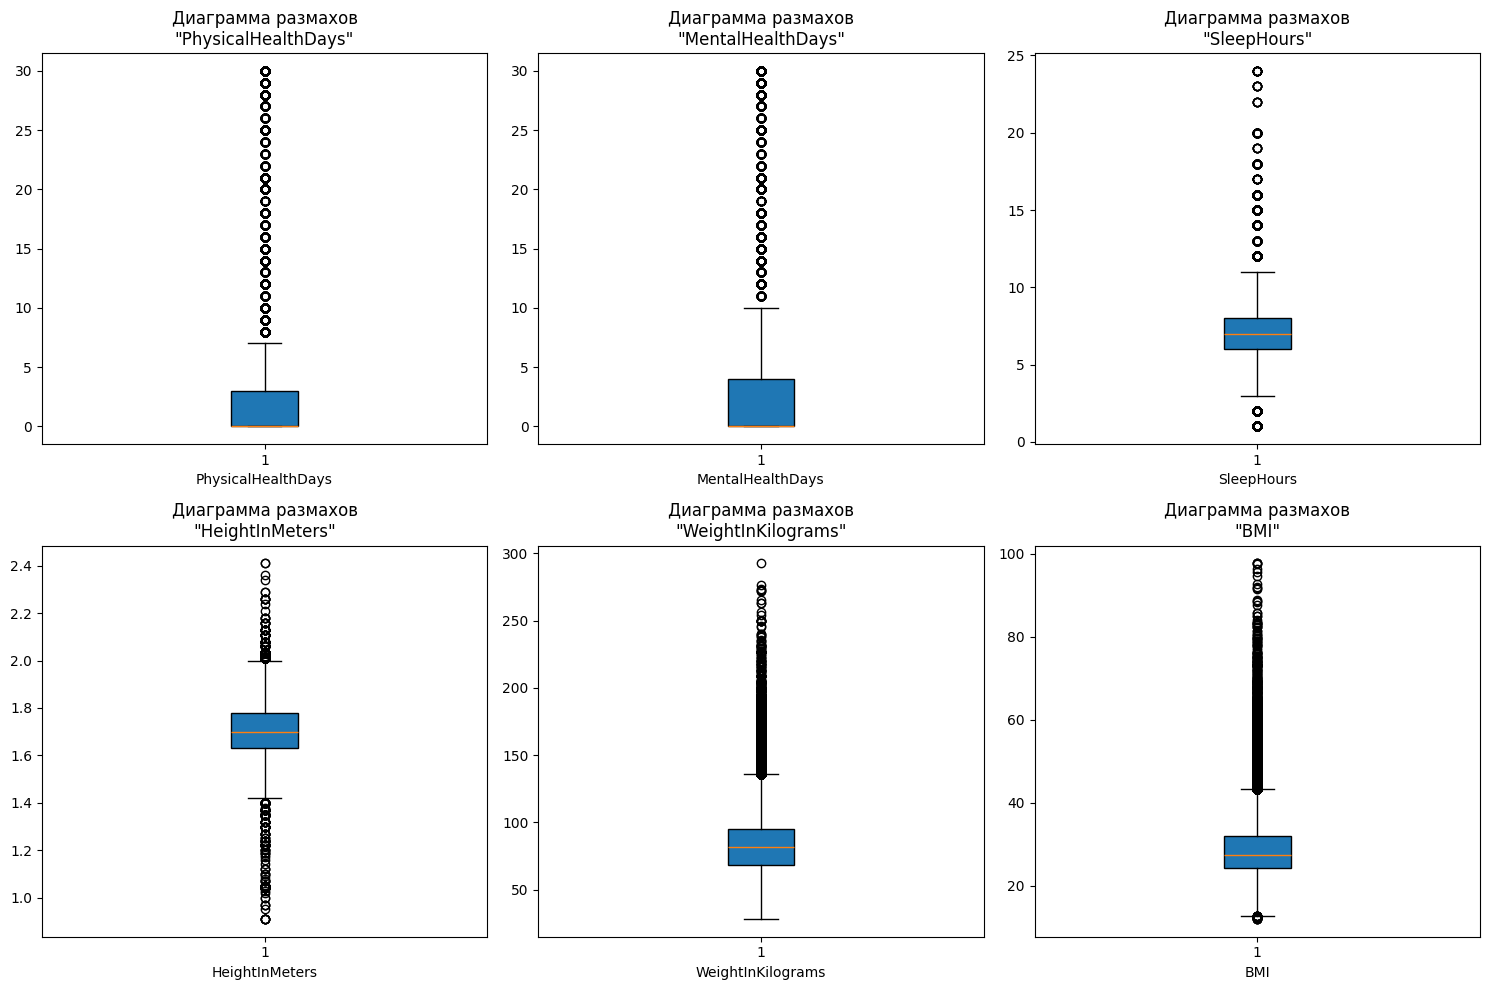

In [257]:
visualize_outliers(df)

In [258]:
def remove_outliers(df: DataFrame, columns: list[str]) -> DataFrame:
    """
    Устраняет выбросы в заданных колонках:
    задает значениям выше максимального значение максимума, ниже минимального - значение минимума
    """
    for column in columns:
        Q1: float = df[column].quantile(0.25)
        Q3: float = df[column].quantile(0.75)
        IQR: float = Q3 - Q1

        lower_bound: float = Q1 - 1.5 * IQR
        upper_bound: float = Q3 + 1.5 * IQR

        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
    return df

Удаляем выбросы

In [259]:
outliers_columns = list(outliers_info[outliers_info["Has Outliers"] == True]["Column"])
df = remove_outliers(df, outliers_columns)

Снова получим данные о выбросах

In [260]:
get_outliers_info(df)

Column  Has Outliers  Outliers Count  Min Value  Max Value  \
0  PhysicalHealthDays         False               0      0.000      7.500   
1    MentalHealthDays         False               0      0.000     10.000   
2          SleepHours         False               0      3.000     11.000   
3      HeightInMeters         False               0      1.405      2.005   
4   WeightInKilograms         False               0     28.120    136.065   
5                 BMI         False               0     12.840     43.320   

      Q1     Q3  
0   0.00   3.00  
1   0.00   4.00  
2   6.00   8.00  
3   1.63   1.78  
4  68.04  95.25  
5  24.27  31.89

Видим, что выбросов не осталось - проверим через диаграммы

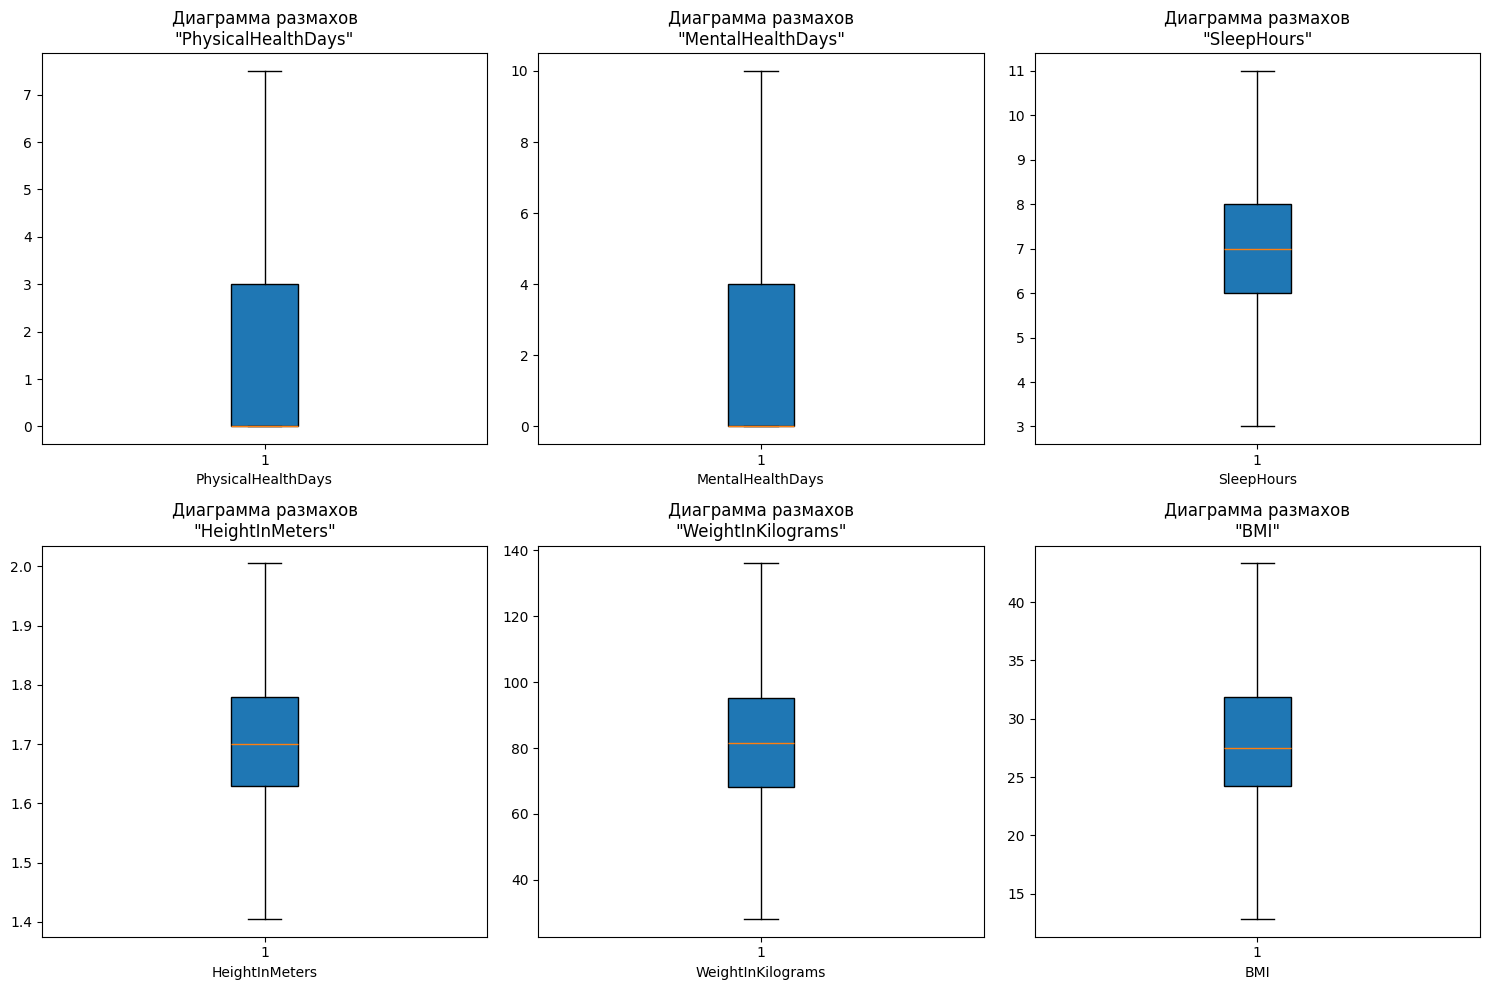

In [261]:
visualize_outliers(df)

## Нормализация числовых признаков

In [262]:
from sklearn import preprocessing

In [263]:
min_max_scaler = preprocessing.MinMaxScaler()

df_norm = df.copy()

numeric_columns = get_numeric_columns(df)

for column in numeric_columns:
    norm_column = column + "Norm"
    df_norm[norm_column] = min_max_scaler.fit_transform(
        df_norm[column].to_numpy().reshape(-1, 1)
    ).reshape(df_norm[column].shape)

df_norm = df_norm.drop(columns=numeric_columns)


df_norm.describe().transpose()

count      mean       std  min       25%       50%  \
PhysicalHealthDaysNorm  246022.0  0.253306  0.385378  0.0  0.000000  0.000000   
MentalHealthDaysNorm    246022.0  0.244973  0.378598  0.0  0.000000  0.000000   
SleepHoursNorm          246022.0  0.501124  0.165569  0.0  0.375000  0.500000   
HeightInMetersNorm      246022.0  0.500401  0.176240  0.0  0.375000  0.491667   
WeightInKilogramsNorm   246022.0  0.510963  0.186742  0.0  0.369818  0.495901   
BMINorm                 246022.0  0.513599  0.194556  0.0  0.375000  0.479659   

                             75%  max  
PhysicalHealthDaysNorm  0.400000  1.0  
MentalHealthDaysNorm    0.400000  1.0  
SleepHoursNorm          0.625000  1.0  
HeightInMetersNorm      0.625000  1.0  
WeightInKilogramsNorm   0.621891  1.0  
BMINorm                 0.625000  1.0

## Конструирование признаков

### Автоматическое конструирование признаков с помощью фреймворка FeatureTools

In [264]:
import featuretools as ft

In [266]:
# Преобразуем датасет с помощью фремйворка
# https://featuretools.alteryx.com/en/stable/getting_started/afe.html

entity_set = ft.EntitySet().add_dataframe(df_norm, "df", make_index=True, index="id")

feature_matrix, feature_defs = ft.dfs(
    entityset=entity_set,
    target_dataframe_name="df",
    max_depth=2
)

feature_matrix: DataFrame
feature_defs: list[ft.Feature]

d:\code\AIM-PIbd-31-Potapov-N-S\lab_3\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\code\AIM-PIbd-31-Potapov-N-S\lab_3\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\code\AIM-PIbd-31-Potapov-N-S\lab_3\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\code\AIM-PIbd-31-Potapov-N-S\lab_3\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not

Выполняем категориальное и унитарное кодирование признаков с помощью FeatureTools

In [267]:
# Сгенерируем новые признаки
# https://featuretools.alteryx.com/en/stable/guides/tuning_dfs.html

feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)
feature_matrix_enc.to_csv("./csv/generated_features.csv", index=False)

print("Было признаков:", len(feature_defs))
print("Стало признаков:", len(features_enc))
print(*features_enc, sep='\n')

Было признаков: 40
Стало признаков: 99
<Feature: State = Washington>
<Feature: State = Maryland>
<Feature: State = Minnesota>
<Feature: State = Ohio>
<Feature: State = New York>
<Feature: State = Texas>
<Feature: State = Florida>
<Feature: State = Kansas>
<Feature: State = Wisconsin>
<Feature: State = Maine>
<Feature: State is unknown>
<Feature: Sex = Female>
<Feature: Sex = Male>
<Feature: Sex is unknown>
<Feature: GeneralHealth = Very good>
<Feature: GeneralHealth = Good>
<Feature: GeneralHealth = Excellent>
<Feature: GeneralHealth = Fair>
<Feature: GeneralHealth = Poor>
<Feature: GeneralHealth is unknown>
<Feature: LastCheckupTime = Within past year (anytime less than 12 months ago)>
<Feature: LastCheckupTime = Within past 2 years (1 year but less than 2 years ago)>
<Feature: LastCheckupTime = Within past 5 years (2 years but less than 5 years ago)>
<Feature: LastCheckupTime = 5 or more years ago>
<Feature: LastCheckupTime is unknown>
<Feature: PhysicalActivities>
<Feature: RemovedT

## Разобьем данные на выборки

In [277]:
from sklearn.model_selection import train_test_split

In [ ]:
prepared_dataset = feature_matrix_enc

target_column = "HadHeartAttack"

X = prepared_dataset.drop(columns=[target_column])  
Y = prepared_dataset[target_column]  

# Обучающая выборка
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=None, stratify=y)

# Тестовая и контрольная выборки
X_test, X_control, Y_test, Y_control = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=None, stratify=Y_temp)

print("Размеры выборок:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Контрольная выборка: {X_control.shape}")

Размеры выборок:
Обучающая выборка: (196817, 98)
Тестовая выборка: (24602, 98)
Контрольная выборка: (24603, 98)


HadHeartAttack
False    232587
True      13435
Name: count, dtype: int64


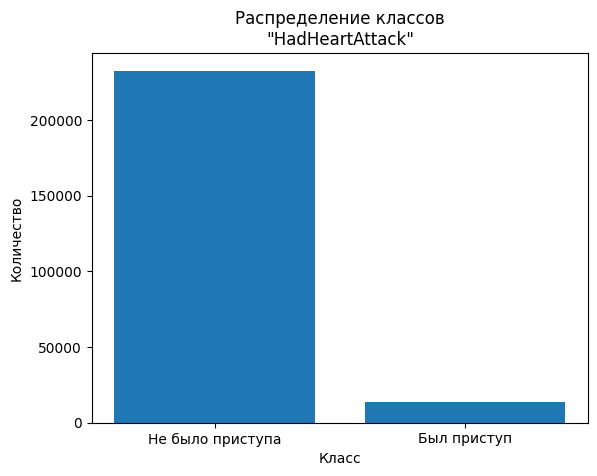

In [317]:
import matplotlib.pyplot as plt

# Подсчет количества объектов каждого класса
class_counts = y.value_counts()
print(class_counts)


class_counts_dict = class_counts.to_dict()

keys = list(class_counts_dict.keys())
vals = list(class_counts_dict.values())

keys[keys.index(True)] = "Был приступ"
keys[keys.index(False)] = "Не было приступа"

# Визуализация
plt.bar(keys, vals)
plt.title(f"Распределение классов\n\"{target_column}\"")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

In [325]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def oversample(X: DataFrame, Y: Series, sampling_strategy=0.5) -> tuple[DataFrame, Series]:
    sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
    x_over, y_over = sampler.fit_resample(X, Y)
    return x_over, y_over 

def undersample(X: DataFrame, Y: Series, sampling_strategy=1) -> tuple[DataFrame, Series]:
    sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
    x_over, y_over = sampler.fit_resample(X, Y)
    return x_over, y_over 

In [327]:
print("Данные до аугментации в обучающей выборке")
print(Y_train.value_counts())

X_train_samplied, Y_train_samplied = X_train, Y_train

# X_train_samplied, Y_train_samplied = oversample(X_train_samplied, Y_train_samplied)
X_train_samplied, Y_train_samplied = undersample(X_train_samplied, Y_train_samplied)
print()
print("Данные после аугментации в обучающей выборке")
print(Y_train_samplied.value_counts())

Данные до аугментации в обучающей выборке
HadHeartAttack
False    186069
True      10748
Name: count, dtype: int64

Данные после аугментации в обучающей выборке
HadHeartAttack
False    10748
True     10748
Name: count, dtype: int64


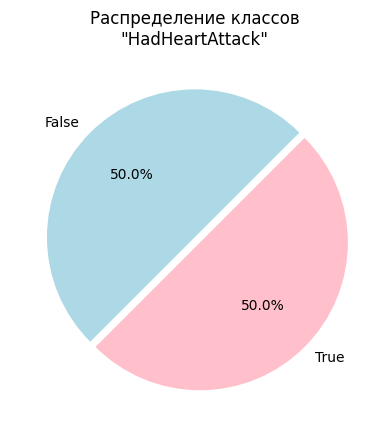

In [349]:
def show_distribution(df: Series, column_name="") -> None:
    plt.pie(
        df.value_counts(),
        labels=class_counts.index,
        autopct='%1.1f%%',
        colors=['lightblue', 'pink'],
        startangle=45,
        explode=(0, 0.05)
    )
    plt.title("Распределение классов" + (f"\n\"{column_name}\"" if column_name else ""))
    plt.show()

show_distribution(Y_train_samplied, column_name=target_column)

## Обучение модели

In [356]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [352]:
model = RandomForestClassifier()

start_time = time.time()

model.fit(X_train, Y_train)

train_time = time.time() - start_time

In [353]:
Y_pred = model.predict(X_test)
Y_pred_proba = model.predict_proba(X_test)[:, 1]

Время обучения модели: 51.06 секунд
ROC-AUC: 0.87
F1-Score: 0.23
Матрица ошибок:
[[23151   108]
 [ 1155   188]]
Отчет по классификации:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97     23259
        True       0.64      0.14      0.23      1343

    accuracy                           0.95     24602
   macro avg       0.79      0.57      0.60     24602
weighted avg       0.94      0.95      0.93     24602



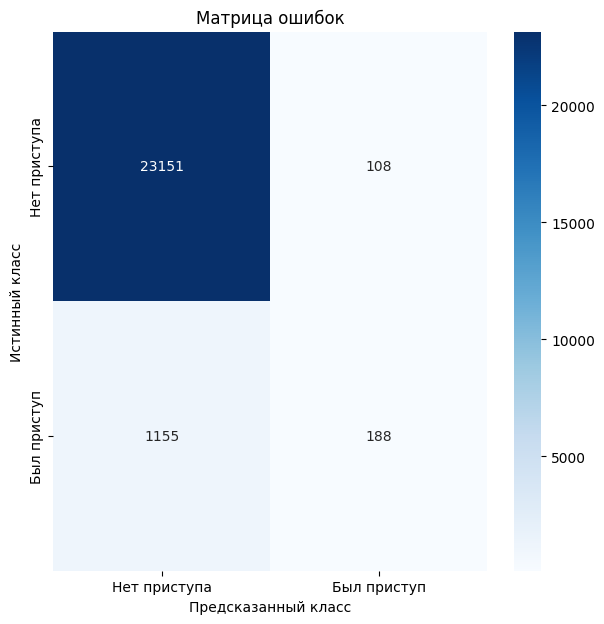

In [360]:
# Метрики
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
f1 = f1_score(Y_test, Y_pred)

conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Вывод результатов
print(f'Время обучения модели: {train_time:.2f} секунд')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'F1-Score: {f1:.2f}')
print('Матрица ошибок:')
print(conf_matrix)
print('Отчет по классификации:')
print(class_report)

# Визуализация матрицы ошибок
plt.figure(figsize=(7, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Нет приступа', 'Был приступ'],
    yticklabels=['Нет приступа', 'Был приступ']
)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()